In [1]:
import os
import torch
from torchsummary import summary

from det3d import torchie
from det3d.models import build_detector
from det3d.torchie.parallel import MegDataParallel
from det3d.torchie.trainer import load_checkpoint

from torch.utils.data import DataLoader
from det3d.datasets import build_dataset
from det3d.torchie.parallel import collate_kitti
from det3d.torchie.trainer.trainer import example_to_device

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

%matplotlib inline

True


In [2]:
cfg = torchie.Config.fromfile("../examples/second/configs/config.py")

In [3]:
# data part
dataset = build_dataset(cfg.data.val)
batch_size = cfg.data.samples_per_gpu
num_workers = cfg.data.workers_per_gpu
data_loader = DataLoader(dataset, batch_size=batch_size, sampler=None, num_workers=num_workers, collate_fn=collate_kitti, shuffle=False,)

In [4]:
# data part
def get_dataset_ids(mode='val'):
    assert mode in ['test', 'train', 'trainval', 'val', 'train_unlabel_val', 'train_unlabel_test']
    id_file_path = "../det3d/datasets/ImageSets/{}.txt".format(mode)
    with open(id_file_path, 'r') as f:
        ids = f.readlines()
    ids = list(map(int, ids))
    return ids

In [5]:
# data part
kitti_dataset = data_loader.dataset         # det3d.datasets.kitti.kitti.KittiDataset
samples = []
valid_ids = get_dataset_ids('test')

In [6]:
for id in [15]:
    index = valid_ids.index(id)
    samples.append(kitti_dataset[index])
batch_samples = collate_kitti(samples)
example = example_to_device(batch_samples, device=torch.device('cuda'))

In [7]:
print([k for k, _ in example.items()])

['metadata', 'points', 'voxels', 'shape', 'num_points', 'num_voxels', 'coordinates', 'anchors', 'calib', 'annos']


In [8]:
example['metadata']

[{'image_prefix': PosixPath('/home/liyue/workspace/datasets/KITTI'),
  'num_point_features': 4,
  'image_idx': 31,
  'image_shape': array([ 375, 1242], dtype=int32),
  'token': '31'}]

In [9]:
example['points'][:3], example['points'].shape, torch.sum(example['points'], dim=0)

(tensor([[ 0.0000, 21.7510,  2.5340,  0.9500,  0.4200],
         [ 0.0000, 21.7620,  2.6050,  0.9500,  0.6000],
         [ 0.0000, 21.7660,  2.6750,  0.9510,  0.5900]], device='cuda:0'),
 torch.Size([18896, 5]),
 tensor([     0.0000, 298681.0000,  15336.3311, -18234.4688,   4971.7002],
        device='cuda:0'))

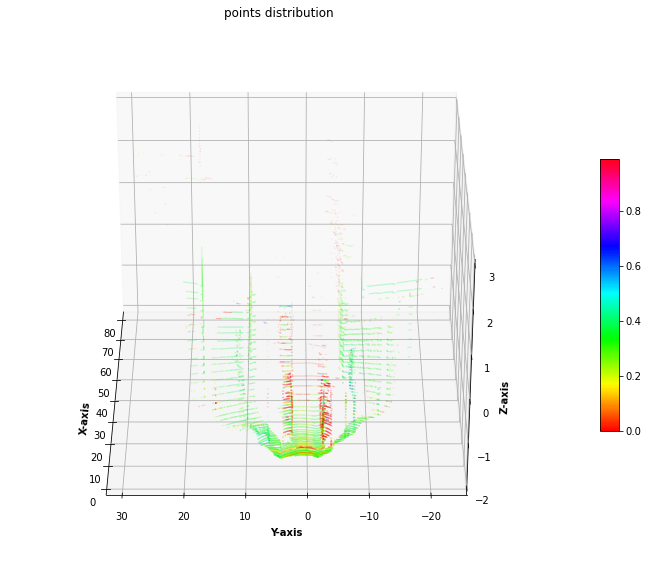

In [10]:
px = 1/plt.rcParams['figure.dpi']
fig = plt.figure(figsize=(1280*px, 720*px))
ax = plt.axes(projection ='3d')
my_cmap = plt.get_cmap('hsv')
x = example['points'][:, 1].cpu()
y = example['points'][:, 2].cpu()
z = example['points'][:, 3].cpu()
c = example['points'][:, 4].cpu()
sctt = ax.scatter3D(x, y, z, c=c, cmap=my_cmap, s=0.005)
ax.set_title('points distribution')
ax.view_init(30, 180)
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 15)
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
plt.show()

In [11]:
example['voxels'][:3], example['voxels'].shape

(tensor([[[21.7510,  2.5340,  0.9500,  0.4200],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],
 
         [[21.7620,  2.6050,  0.9500,  0.6000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]],
 
         [[21.7660,  2.6750,  0.9510,  0.5900],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]], device='cuda:0'),
 torch.Size([15212, 5, 4]))

In [12]:
example['shape']

array([[1408, 1600,   40]])

In [13]:
example['num_points'][:20], example['num_points'].shape

(tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        device='cuda:0', dtype=torch.int32),
 torch.Size([15212]))

In [14]:
example['num_voxels']

tensor([15212], device='cuda:0')

In [15]:
example['coordinates'][:5], example['coordinates'].shape

(tensor([[  0,  39, 850, 435],
         [  0,  39, 852, 435],
         [  0,  39, 853, 435],
         [  0,  39, 854, 434],
         [  0,  39, 855, 435]], device='cuda:0', dtype=torch.int32),
 torch.Size([15212, 4]))

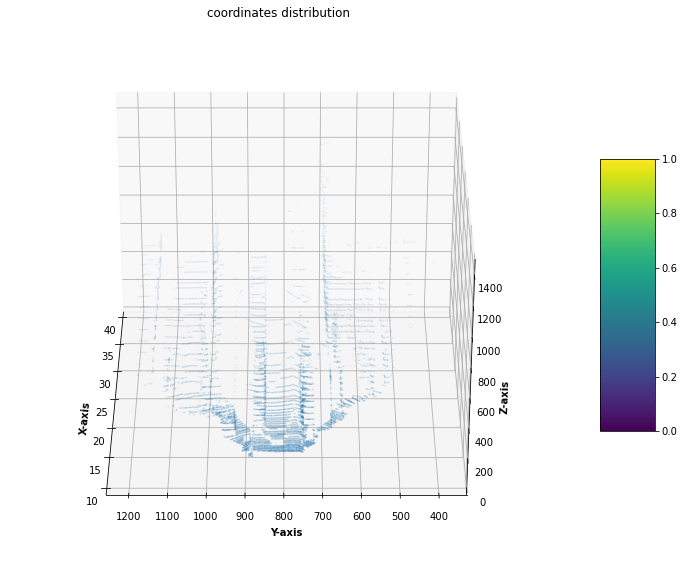

In [16]:
px = 1/plt.rcParams['figure.dpi']
fig = plt.figure(figsize=(1280*px, 720*px))
ax = plt.axes(projection ='3d')
x = example['coordinates'][:, 1].cpu()
y = example['coordinates'][:, 2].cpu()
z = example['coordinates'][:, 3].cpu()
sctt = ax.scatter3D(x, y, z, s=0.005)
ax.set_title('coordinates distribution')
ax.view_init(30, 180)
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
plt.show()

In [17]:
example['anchors'][0][...,5,:], example['anchors'][0].shape

(tensor([[  1.0000, -39.8000,  -1.0000,   1.6000,   3.9000,   1.5600,   1.5700]],
        device='cuda:0'),
 torch.Size([1, 70400, 7]))

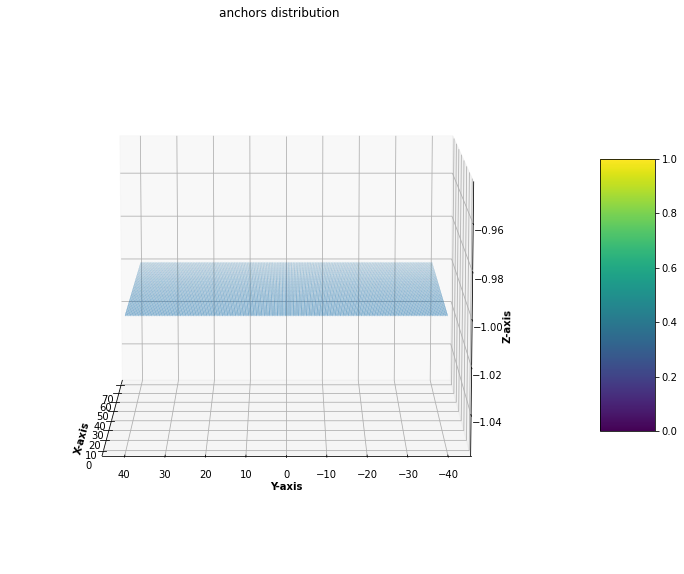

In [18]:
px = 1/plt.rcParams['figure.dpi']
fig = plt.figure(figsize=(1280*px, 720*px))
ax = plt.axes(projection ='3d')
x = example['anchors'][0][0][:, 0].cpu()
y = example['anchors'][0][0][:, 1].cpu()
z = example['anchors'][0][0][:, 2].cpu()
sctt = ax.scatter3D(x, y, z, s=0.002)
ax.set_title('anchors distribution')
ax.view_init(10, 180)
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
plt.show()

In [19]:
example['calib']

{'rect': tensor([[[ 0.9999,  0.0098, -0.0074,  0.0000],
          [-0.0099,  0.9999, -0.0043,  0.0000],
          [ 0.0074,  0.0044,  1.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
        dtype=torch.float64),
 'Trv2c': tensor([[[ 7.5337e-03, -9.9997e-01, -6.1660e-04, -4.0698e-03],
          [ 1.4802e-02,  7.2807e-04, -9.9989e-01, -7.6316e-02],
          [ 9.9986e-01,  7.5238e-03,  1.4808e-02, -2.7178e-01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
        device='cuda:0', dtype=torch.float64),
 'P2': tensor([[[7.2154e+02, 0.0000e+00, 6.0956e+02, 4.4857e+01],
          [0.0000e+00, 7.2154e+02, 1.7285e+02, 2.1638e-01],
          [0.0000e+00, 0.0000e+00, 1.0000e+00, 2.7459e-03],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]]], device='cuda:0',
        dtype=torch.float64),
 'frustum': tensor([[[[[ 2.7114e-01,  5.8722e-02, -7.1781e-02],
            [ 2.7115e-01,  5.8728e-02, -7.2301e-02],
            [ 2.7115e-01,

In [20]:
example['annos']

array([{'boxes': array([[ 1.24901945e+01,  3.19828260e+00, -8.75990480e-01,
         1.66999996e+00,  3.80999994e+00,  1.64999998e+00,
        -1.60000002e+00],
       [ 8.75001136e+00, -3.16372953e+00, -8.67281997e-01,
         1.50999999e+00,  3.09999990e+00,  1.51999998e+00,
        -1.59000003e+00],
       [ 1.34302127e+01, -2.88263489e+00, -8.60406552e-01,
         1.58000004e+00,  3.52999997e+00,  1.52999997e+00,
        -1.59000003e+00],
       [ 2.25567532e+01,  3.49666553e+00, -2.26066578e-02,
         2.05999994e+00,  5.42000008e+00,  2.59999990e+00,
         1.55999994e+00],
       [ 2.66997560e+01, -2.69067814e+00, -7.84707430e-01,
         1.60000002e+00,  3.71000004e+00,  1.46000004e+00,
        -1.53999996e+00],
       [ 5.21904385e+01, -1.72523721e+00, -4.73138346e-01,
         1.82000005e+00,  4.40999985e+00,  1.97000003e+00,
        -1.58000004e+00]]), 'names': array(['Car', 'Car', 'Car', 'Truck', 'Car', 'Van'], dtype='<U8')}],
      dtype=object)

In [21]:
samples = []
for id in [15]:
    index = valid_ids.index(id)
    samples.append(kitti_dataset[index])
batch_samples = collate_kitti(samples)
example = example_to_device(batch_samples, device=torch.device('cuda'))

In [22]:
del example['metadata']
#del example['points']
#del example['voxels']
#del example['shape']
#del example['num_points']
#del example['num_voxels']
#del example['coordinates']
#del example['anchors']
del example['calib']
del example['annos']

In [23]:
res = {
            "lidar": {
                "type": "lidar",
                "points": example['points'][:, 1:5].cpu().numpy(),
                "targets": None,      # include cls_labels & reg_targets
            },
            "mode": "test",
            "metadata": None
        }

In [24]:
from det3d.datasets.pipelines import Compose
pipeline = Compose(cfg.online_execute_pipeline)

In [25]:
data, _ = pipeline(res, None)
examp = collate_kitti([data])

In [26]:
examp

{'metadata': [None],
 'points': tensor([[ 0.0000e+00,  2.1751e+01,  2.5340e+00,  9.5000e-01,  4.2000e-01],
         [ 0.0000e+00,  2.1762e+01,  2.6050e+00,  9.5000e-01,  6.0000e-01],
         [ 0.0000e+00,  2.1766e+01,  2.6750e+00,  9.5100e-01,  5.9000e-01],
         ...,
         [ 0.0000e+00,  6.5520e+00, -5.4000e-02, -1.7150e+00,  1.5000e-01],
         [ 0.0000e+00,  6.5500e+00, -3.3000e-02, -1.7150e+00,  2.9000e-01],
         [ 0.0000e+00,  6.5480e+00, -1.3000e-02, -1.7140e+00,  2.5000e-01]]),
 'voxels': tensor([[[ 2.1751e+01,  2.5340e+00,  9.5000e-01,  4.2000e-01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],
 
         [[ 2.1762e+01,  2.6050e+00,  9.5000e-01,  6.0000e-01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,

In [27]:
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
checkpoint_path = os.path.join("../exp_se_ssd_v1_8", "se-ssd-model.pth")
checkpoint = load_checkpoint(model, checkpoint_path, map_location="cpu")
model = MegDataParallel(model, device_ids=[0])

In [28]:
with torch.no_grad():
    # outputs: predicted results in lidar coord.
    outputs = model(examp, return_loss=False, rescale=True)

In [29]:
outputs

[{'box3d_lidar': tensor([[ 12.6476,   3.3091,  -0.8771,   1.6708,   4.2013,   1.5731,   4.6632],
          [  8.8111,  -3.2448,  -0.8363,   1.5734,   3.2481,   1.5917,   4.7347],
          [ 26.6175,  -2.7054,  -0.7917,   1.6741,   3.5609,   1.4714,   4.7462],
          [ 13.5381,  -2.8619,  -0.9411,   1.5914,   3.5972,   1.5351,   4.6381],
          [ 22.2957,   3.4187,  -0.2555,   2.0526,   6.1297,   2.5000,   1.5713],
          [ 22.5497,  15.8281,  -1.0221,   1.6148,   4.1045,   1.4306,   4.6863],
          [ 52.4032,  -1.8464,  -0.5163,   1.9294,   4.7983,   1.9648,   4.7042],
          [  2.3614,  -2.8141,  -1.0457,   1.5843,   4.0110,   1.4402,   1.7379],
          [ 21.3408, -14.2113,  -0.5356,   1.6474,   4.0538,   1.5164,   2.0998]],
         device='cuda:0'),
  'scores': tensor([0.5280, 0.5235, 0.4957, 0.4898, 0.2779, 0.2381, 0.1755, 0.1497, 0.1108],
         device='cuda:0'),
  'label_preds': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  'metadata': None}]

In [30]:
with torch.no_grad():
    # outputs: predicted results in lidar coord.
    outputs = model(example, return_loss=False, rescale=True)

In [31]:
outputs

[{'box3d_lidar': tensor([[ 12.6476,   3.3091,  -0.8771,   1.6708,   4.2013,   1.5731,   4.6632],
          [  8.8111,  -3.2448,  -0.8363,   1.5734,   3.2481,   1.5917,   4.7347],
          [ 26.6175,  -2.7054,  -0.7917,   1.6741,   3.5609,   1.4714,   4.7462],
          [ 13.5381,  -2.8619,  -0.9411,   1.5914,   3.5972,   1.5351,   4.6381],
          [ 22.2957,   3.4187,  -0.2555,   2.0526,   6.1297,   2.5000,   1.5713],
          [ 22.5497,  15.8281,  -1.0221,   1.6148,   4.1045,   1.4306,   4.6863],
          [ 52.4032,  -1.8464,  -0.5163,   1.9294,   4.7983,   1.9648,   4.7042],
          [  2.3614,  -2.8141,  -1.0457,   1.5843,   4.0110,   1.4402,   1.7379],
          [ 21.3408, -14.2113,  -0.5356,   1.6474,   4.0538,   1.5164,   2.0998]],
         device='cuda:0'),
  'scores': tensor([0.5280, 0.5235, 0.4957, 0.4898, 0.2779, 0.2381, 0.1755, 0.1497, 0.1108],
         device='cuda:0'),
  'label_preds': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  'metadata': None}]